In [73]:
import sys
sys.version

'3.8.5 (default, Jul 21 2020, 10:48:26) \n[Clang 11.0.3 (clang-1103.0.32.62)]'

In [150]:
import json

from matplotlib import pyplot as plt
import pandas as pd

pd.set_option('max_columns', 0)

def set_colors(fg='w', bg='#222'):
    plt.rcParams.update({
        'xtick.color': fg,
        'ytick.color': fg,
        'text.color': fg,
        'axes.labelcolor': fg,
        'axes.edgecolor': fg,
        'axes.facecolor': bg,
        'figure.facecolor': bg,
    })
set_colors()

## new output

In [152]:
# -> 10x smaller without confirmed (2.7M)
# ->  7x smaller with    confirmed (3.4M)
!ls -lh ../output/table.json
!ls -lh ../output/info.json
with open('../output/table.json') as f:
    table = json.load(f)
with open('../output/info.json') as f:
    info = json.load(f)

-rw-r--r--  1 ast  staff   3.4M Oct 11 15:13 ../output/table.json
-rw-r--r--  1 ast  staff    31K Oct 11 15:13 ../output/info.json


In [110]:
def fillnarows(table):
    return [row if row is not None else [None] * 3 for row in table]
pd.DataFrame(fillnarows(table[-1]), index=info['rows'], columns=info['cols'])

,new,recovered,deaths
Afghanistan,77.0,33058.0,1472.0
Albania,167.0,9304.0,413.0
Algeria,146.0,37067.0,1789.0
Andorra,128.0,1814.0,55.0
Angola,73.0,2685.0,212.0
...,...,...,...
Western Sahara,0.0,8.0,1.0
World,287413.0,25578672.0,1067114.0
Yemen,1.0,1329.0,593.0
Zambia,38.0,14439.0,336.0


In [140]:
df = pd.DataFrame(
    [row for _ in map(fillnarows, table) for row in _],
    index=pd.MultiIndex.from_product((info['dates'], info['rows'])),
    columns=info['cols'],
)
df.index = df.index.set_names(('date', 'country'))
print(df.values.shape)
df.head()

(262262, 3)


new  recovered  deaths
date       country                            
2020-01-22 Afghanistan  NaN        NaN     NaN
           Albania      NaN        NaN     NaN
           Algeria      NaN        NaN     NaN
           Andorra      NaN        NaN     NaN
           Angola       NaN        NaN     NaN

In [141]:
df.loc[(slice(info['dates'][0], info['dates'][-1]), 'Afghanistan'), :]
df.loc[(slice(None), 'Afghanistan'), :]
idx = pd.IndexSlice
df.loc[idx[:, 'Afghanistan'], :]

,,new,recovered,deaths
date,country,,,
2020-01-22,Afghanistan,NaN,NaN,NaN
2020-01-23,Afghanistan,NaN,NaN,NaN
2020-01-24,Afghanistan,NaN,NaN,NaN
2020-01-25,Afghanistan,NaN,NaN,NaN
2020-01-26,Afghanistan,NaN,NaN,NaN
...,...,...,...,...
2020-10-05,Afghanistan,81.0,32879.0,1466.0
2020-10-06,Afghanistan,64.0,32977.0,1467.0
2020-10-07,Afghanistan,62.0,33045.0,1469.0


In [142]:
df.xs('Afghanistan', level=1)  # drop_level=True

,new,recovered,deaths
date,,,
2020-01-22,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN
...,...,...,...
2020-10-05,81.0,32879.0,1466.0
2020-10-06,64.0,32977.0,1467.0
2020-10-07,62.0,33045.0,1469.0


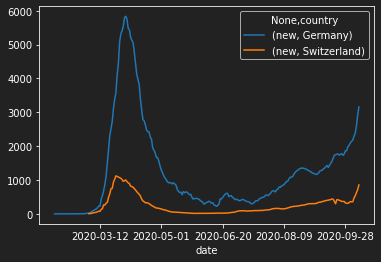

In [151]:
df.unstack().rolling(7).mean().loc[:, idx['new', ('Switzerland', 'Germany')]].plot();

## old output

In [75]:
path = '../output/bydate.json'
bydate = json.load(open(path))
!ls -lh $path
len(bydate)

-rw-r--r--  1 ast  staff    25M Oct 10 09:13 ../output/bydate.json


262

In [76]:
# level: country, state, county (not currently)
row = bydate[-1]
data = row['data']
row.keys(), row['date'], list(data.keys())[0], data['Afghanistan']

(dict_keys(['date', 'data']),
 '2020-10-09',
 'Afghanistan',
 {'level': 'country',
  'confirmed': 39693,
  'deaths': 1472,
  'recovered': 33058,
  'active': 5163,
  'pop': 38928341,
  'new': 77})

In [96]:
def get_country(country):
    return pd.DataFrame([
        dict(date=row['date'], **row['data'][country])
        for row in bydate if country in row['data']
    ]).set_index('date')
country = get_country('Afghanistan')

In [97]:
# so confirmed is basically == cumsum(new)
(country.confirmed - country.new.cumsum()).value_counts()

1.0    228
dtype: int64

In [99]:
# so recovered is basically == confirmed - deaths - active
(country.confirmed - country.deaths - country.active - country.recovered).value_counts()

0     202
1      13
21      3
7       3
23      2
4       2
20      1
16      1
11      1
5       1
dtype: int64

In [77]:
keys = pd.DataFrame(({
    'key': key,
    'key0': key.split(',')[0] if ',' in key else None,
    'level': value['level']
} for key, value in data.items()))
keys.level.value_counts()

state      575
country    187
i18n         1
Name: level, dtype: int64

In [78]:
keys.key0.value_counts()

Russia            83
US                58
Japan             49
India             37
Colombia          34
China             33
Mexico            32
Ukraine           27
Brazil            27
Peru              26
Italy             21
Sweden            21
Spain             20
Chile             17
Netherlands       17
Germany           17
United Kingdom    15
Canada            14
France            10
Australia          8
Pakistan           7
Denmark            2
Name: key0, dtype: int64

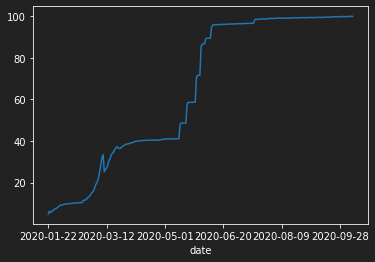

In [79]:
sizes = pd.DataFrame(({'date': _['date'], 'kb_per_day': len(json.dumps(_['data']))/1024} for _ in bydate))
sizes.set_index('date').kb_per_day.plot();

In [80]:
bydate_countries = [
    dict(
        date=row['date'],
        data={
            k: v
            for k, v in row['data'].items()
            if v['level'] == 'country'
        }
    )
    for row in bydate
]
len(json.dumps(bydate_countries)) / len(json.dumps(bydate))

0.3048836727665223

## covid_19

In [81]:
df = pd.read_csv('covid_19/COVID19_Fallzahlen_CH_total_v2.csv')
print(len(df))
df.tail()

5440


,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,ncumul_confirmed_non_resident,current_hosp_non_resident,current_quarantined_riskareatravel,current_quarantined_total,current_hosp_resident
5435,2020-10-09,11:15,GL,NaN,197.0,NaN,0.0,NaN,NaN,NaN,13.0,https://www.gl.ch/public/upload/assets/30317/C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5436,2020-10-09,12:00,AI,NaN,52.0,NaN,NaN,NaN,NaN,NaN,0.0,https://www.ai.ch/themen/gesundheit-alter-und-...,9.0,12.0,NaN,NaN,NaN,NaN,NaN
5437,2020-10-09,14:30,ZH,NaN,9295.0,NaN,36.0,NaN,4.0,NaN,148.0,https://www.zh.ch/de/gesundheit/coronavirus.html,1081.0,2967.0,NaN,NaN,NaN,NaN,NaN
5438,2020-10-09,14:40,AR,NaN,218.0,NaN,1.0,0.0,NaN,NaN,3.0,https://www.ar.ch/verwaltung/departement-gesun...,26.0,74.0,NaN,NaN,NaN,NaN,NaN
5439,2020-10-09,16:00,UR,NaN,173.0,NaN,0.0,NaN,NaN,138.0,7.0,https://www.ur.ch/themen/2962,NaN,133.0,NaN,NaN,NaN,NaN,NaN


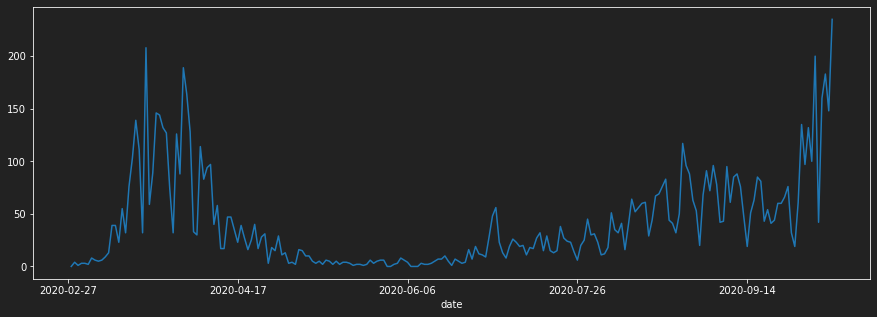

In [82]:
# new ZH cases
plt.figure(figsize=(15, 5))
df[df.abbreviation_canton_and_fl == 'ZH'].set_index('date').ncumul_conf.diff().plot();

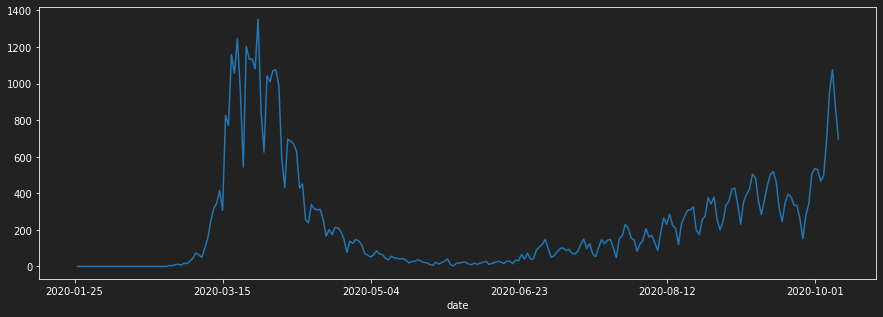

In [83]:
# new CH cases (filled)
plt.figure(figsize=(15, 5))
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').stack().reset_index().rename(columns={0: 'ncumul_conf'}).groupby('date').ncumul_conf.sum().diff().plot();

In [84]:
# latest new cases by canton (filled)
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').diff().tail(10).astype(int)

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,GR,JU,LU,NE,NW,OW,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30,18,1,9,45,2,5,0,16,60,3,9,1,14,13,2,1,23,4,9,11,9,6,0,79,20,8,135
2020-10-01,16,1,0,52,6,3,1,25,76,2,8,7,8,27,4,0,36,6,10,9,6,5,1,102,22,6,97
2020-10-02,16,1,6,55,5,6,1,24,60,0,14,1,0,13,2,1,33,3,8,9,14,10,3,84,25,3,132
2020-10-03,24,0,0,48,10,13,3,24,68,0,5,7,0,5,2,0,22,0,0,14,11,0,0,95,15,0,100
2020-10-04,10,0,0,65,6,7,3,26,37,0,0,1,0,15,3,0,7,0,0,0,7,0,0,88,19,0,200
2020-10-05,16,1,12,38,3,4,1,11,90,4,7,8,35,43,2,3,75,7,23,26,9,21,5,131,34,35,42
2020-10-06,43,0,0,65,11,6,3,38,134,1,24,22,14,43,10,5,51,3,5,34,25,17,0,155,60,25,160
2020-10-07,55,1,0,84,14,14,1,47,118,1,16,17,21,46,6,13,73,6,24,38,25,39,14,136,58,26,183
2020-10-08,58,3,17,98,13,15,5,50,156,4,22,32,43,0,9,5,29,5,0,56,32,40,2,0,0,28,148


In [85]:
df[df.date == df.date.max()]

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,ncumul_confirmed_non_resident,current_hosp_non_resident,current_quarantined_riskareatravel,current_quarantined_total,current_hosp_resident
5419,2020-10-09,NaN,BL,NaN,1266.0,NaN,4.0,1.0,0.0,1135.0,37.0,https://www.baselland.ch/politik-und-behorden/...,76.0,209.0,NaN,NaN,NaN,NaN,NaN
5420,2020-10-09,NaN,FL,NaN,139.0,NaN,1.0,NaN,NaN,117.0,1.0,https://www.llv.li/files/ag/aktuelle-fallzahle...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5421,2020-10-09,NaN,FR,NaN,2743.0,NaN,12.0,2.0,NaN,177.0,102.0,https://www.fr.ch/sites/default/files/2020-10/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5422,2020-10-09,NaN,GE,NaN,NaN,NaN,48.0,7.0,NaN,NaN,NaN,https://www.ge.ch/document/21502/telecharger,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5423,2020-10-09,NaN,GR,NaN,1217.0,NaN,1.0,0.0,0.0,NaN,50.0,https://services1.arcgis.com/YAuo6vcW85VPu7OE/...,116.0,756.0,NaN,NaN,NaN,NaN,NaN
5424,2020-10-09,NaN,LU,NaN,1400.0,NaN,7.0,2.0,NaN,NaN,24.0,https://gesundheit.lu.ch/themen/Humanmedizin/I...,183.0,259.0,NaN,NaN,NaN,NaN,NaN
5425,2020-10-09,NaN,NW,NaN,195.0,NaN,0.0,0.0,NaN,NaN,4.0,http://www.nw.ch/coronastatistik,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5426,2020-10-09,NaN,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://stada.sg.ch/covid/ContactTracing.html,324.0,825.0,NaN,NaN,NaN,NaN,NaN
5427,2020-10-09,00:00,OW,NaN,160.0,NaN,1.0,NaN,NaN,NaN,0.0,https://www.ow.ch/dl.php/de/5f8072155ea23/OW-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5428,2020-10-09,08:00,BE,NaN,4105.0,NaN,39.0,7.0,3.0,NaN,104.0,https://www.besondere-lage.sites.be.ch/besonde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
